# Simpson's paradox and causal inference with observational data

__TL;DR__: Simpson's paradox is a favorite mathematical curiosity. It is inextricably linked to causal inference. When building machine learning models on real-world medical evidence, Simpson's Paradox is something we should be prepared for. This is one aspect of drawing inferences from observational data that marks it as different from randomized controlled trials. When we are interested in making predictions without intervention, Simpson's Paradox is not a danger, merely a confusing annoyance; it won't lead us to false predictions, though it may hamper interpretation. However, when we want to draw causal conclusions, some assumptions about the world are necessary to escape the paradox.

In [1]:
__author__ = 'Adam Foster'

## Contents

0. [Prediction and causal inference with observational data](#Prediction-and-causal-inference-with-observational-data)
0. [Prediction vs. causal inference](#Prediction-vs.-causal-inference)
0. [Data in this post](#Data-in-this-post)
0. [Simpson's paradox: take 1](#Simpson's-paradox:-take-1)
0. [Simpson's paradox: take 2](#Simpson's-paradox:-take-2)
0. [For prediction, there is no paradox](#For-prediction,-there-is-no-paradox)
0. [Protecting against Simpson's Paradox when venturing causal inferences](#Protecting-against-Simpson's-Paradox-when-venturing-causal-inferences)   
0. [Conclusion](#Conclusion)
0. [Appendix A: Data simulation](#Appendix-A:-Data-simulation)
0. [Appendix B: Temporal ordering?](#Appendix-B:-Temporal-ordering?)
0. [References](#References)

$\newcommand{\prob}{\mathbb{P}}$
$\newcommand{\expect}{\mathbb{E}}$
$\newcommand{\cond}{\,|\,}$

## Prediction and causal inference with observational data

In the world of healthcare, there is increasing pressure to leverage observational data, collected amongst a broad population outside of experimental controls, to better understand efficacy, safety, and the value of treatments in practice. The data for these efforts can come from numerous, disparate sources: prescription patterns, public health indicators, medical ontologies, and more traditional health data sources like insurance claims and electronic health records. A single study might integrate many such data sets to produce a vast, detailed  picture of the relevant populations, behaviors, and responses.

In this post, we consider two different goals one might have for studies using such observational data:

1. _Prediction_: To make predictions about future outcomes, based on models we train from the data we have now.

2. _Causal inference_: To understand which of the many hundreds of variables in our model are driving the change &ndash; which have a causative effect on the outcome.

[Simpson's Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox) (a special case of the [reversal paradox](https://ete-online.biomedcentral.com/articles/10.1186/1742-7622-5-2) \cite{tu2008}) is a famous counter-intuitive result in statistics showing that results can appear, disappear, or even become reversed within the same data set depending on how one chooses to break the population into subgroups. This is relevant to both goals, but it affects them differently. For the prediction problem, Simpson's Paradox is really just an annoyance. For the causal inference problem, it is more serious.

Let's start by stating the two goals more precisely and identifying just how they differ.

## Prediction vs. causal inference

An associational predictive statement might look like,

> People who take this treatment are likely to get better

where the intention is identify a pattern that one expects to hold for new cases, without making any claim about _why_ the pattern occurs.

In contrast, a causal statement like 

> This treatment makes people get better

explicates the nature of the connection between treatment and outcome and implicitly says that people who don't get the treatment will not get better (assuming everything else is held constant). We expect the predictive statement also to be true if the causal one is, but the reverse is not true. As the saying goes, correlation does not imply causation.

In the context of healthcare, making a causal claim where only a predictive one holds can have very serious consequences. The randomized control design of clinical trials is meant to help us avoid such mistakes. With observational data, the risks of such mistakes are greater, and Simpson's Paradox helps us to see why, as it results from faulty causal reasoning \cite{pearl2003}. In this way, the paradox serves as a warning bell that we need some solid causal assumptions before we can proceed with causal inference from our observational data.


## Data in this post

This post tells a story about making causal inference using real-world evidence. However, **all the data in the post are simulated**. The primary advantage of this is that it allows us to specify the data generation process for ourselves, which allows us to control the correlations and causal effects to expose interesting patterns.

## Simpson's paradox: take 1

In our first example, we illustrate a classic Simpson's Paradox pattern: a relationship that holds for the overall population is reversed for every subgroup.

Suppose we wish to study the effect of two treatments: Treatment 1 (existing therapy) and Treatment 2 (experimental gene therapy) on response. A lower response is better. Suppose the data arose from a real-world study into the two treatments, thereby creating inherent uncertainty about how to properly define our model. 

We begin by plotting the response of each patient, graphically separated by which treatment they were receiving (all code for this post is [available here](https://github.com/roaminsight/roamresearch/tree/master/BlogPosts/Simpsons_paradox_and_causal_inference)):

In [2]:
%matplotlib inline
from causal_inference_support import *

In [3]:
data = get_dataframe(data_generator1(), 200)

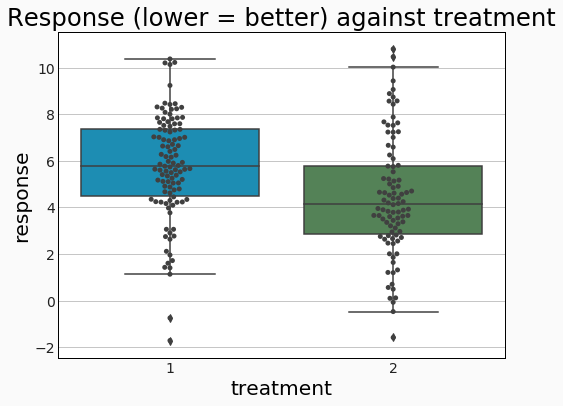

In [4]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='treatment', y='response', data=data)
sns.swarmplot(x='treatment', y='response', data=data, color='.25')
plt.title("Response (lower = better) against treatment")
plt.show()

The means for each group are

In [5]:
data.groupby('treatment').mean()

,response
treatment,
1,5.752949
2,4.455171


Is the difference between the means significant? A classical test for this is Student's $t$-test. Let's perform this test now:

In [6]:
run_ttest(data, 'treatment', 1, 2, 'response')

Performing t-test assuming equal variance: p-value is 0.00019


A natural conclusion at this point: "Treatment 2 is a more effective treatment. The result is significant."

And if we had only treatment and response data, our analysis would have to stop there. But if we live in a world of connected health data, we'll likely know a lot more than that about our participants.

Suppose, then, that we use connections between our data and public geographical data to find that people living in urban areas experience the disease differently than those living in rural areas. Let's consider the effect of the two treatments on urban and rural dwellers separately:

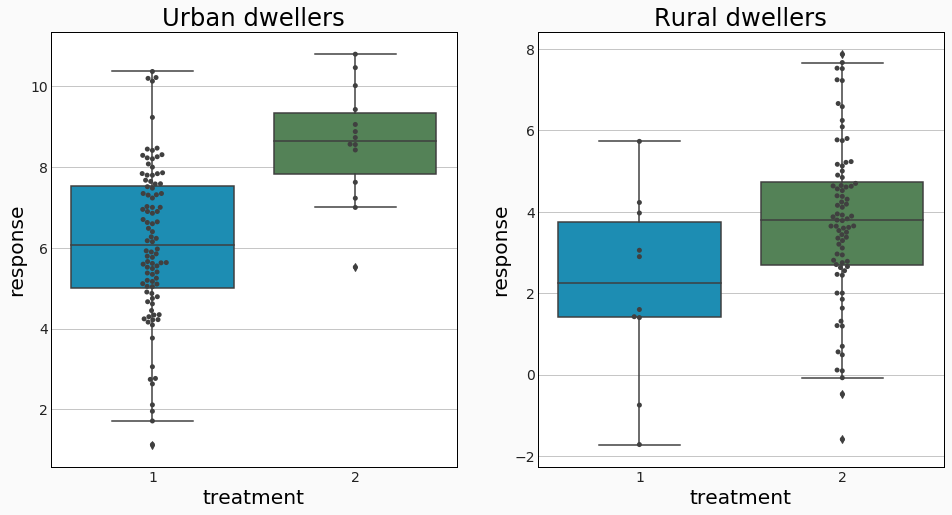

In [7]:
fig, axes = plt.subplots(1,2, figsize=(16, 8))
for location, ax in zip(['Urban', 'Rural'], axes):
    sns.boxplot(ax=ax, x='treatment', y='response', 
                data=data[data['location'] == location])
    sns.swarmplot(ax=ax, x='treatment', y='response', 
                  data=data[data['location'] == location], color='.25')
    ax.set_title("{} dwellers".format(location))

Now the group means are

In [8]:
data.groupby(['location', 'treatment']).mean()

response
location treatment          
Rural    1          2.186409
         2          3.730602
Urban    1          6.124464
         2          8.595568

In [9]:
print("Urban")
run_ttest(data[data['location'] == 'Urban'], 'treatment', 1, 2, 'response')
print("Rural")
run_ttest(data[data['location'] == 'Rural'], 'treatment', 1, 2, 'response')

Urban
Performing t-test assuming equal variance: p-value is 9.2e-06
Rural
Performing t-test assuming equal variance: p-value is 0.025


This is a classic example of Simpson's Paradox. Just above, we showed that, for the population overall, Treatment 2 appears better than Treatment 1. *But*, for both subgroups considered on their own, Treatment 1 is better than Treatment 2.
 
A story to explain the paradox in our example is as follows. People living in urban areas who suffer much more from the disease (perhaps due to higher pollution levels in cities) are more likely to use Treatment 1. Perhaps it is more available, or better marketed here. People living in rural areas where the effects of the disease are less, tend to use Treatment 2 even though it's not as good at curing the disease. When we look at the whole population, Treatment 2 manages to look better because it's overwhelmingly taken by people in rural areas where the effects of the disease aren't so severe.

## Simpson's paradox: take 2

In the previous example, it's natural to resolve the apparent paradox by including subgroup information in the estimate of causal effects. We now consider an example where subgroup information leads us astray.

We still have two treatment options &ndash; Treatment 1 and Treatment 2. Now however, the disease is the same for urban and rural dwellers. The third variable is $S$. Say $S=1$ indicates that the patient went scuba diving in the last month, and $S=0$ indicates they did not. We look at the whole population first:

In [10]:
data2 = get_dataframe(data_generator2(), 120)

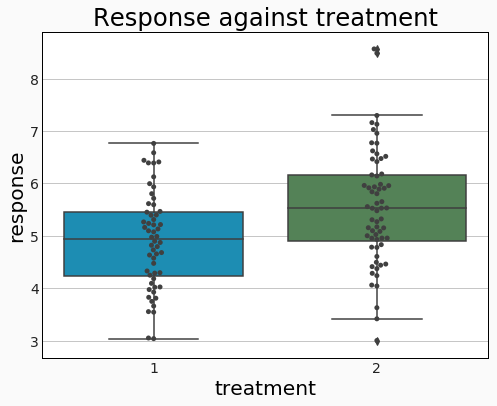

In [11]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='treatment', y='response', data=data2)
sns.swarmplot(x='treatment', y='response', data=data2, color='.25')
plt.title("Response against treatment")
plt.show()

And, as before, let's look at the response means for the two treatments:

In [12]:
data2.drop('scuba_diving', 1).groupby('treatment').mean()

,response
treatment,
1,4.909491
2,5.547824


This looks like a clear result that Treatment 1 is better than Treatment 2. However, the urban–rural example should be a warning to us. Let's break down the data into scuba divers and non-scuba divers:

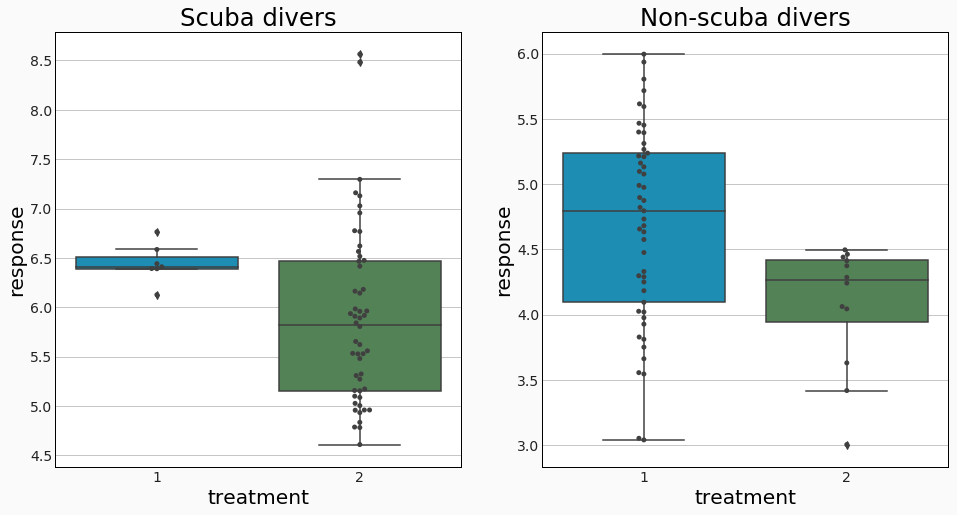

In [13]:
fig, axes = plt.subplots(1,2, figsize=(16, 8))
for scuba, ax in zip([True, False], axes):
    sns.boxplot(ax=ax, x='treatment', y='response', 
                data=data2[data2['scuba_diving'] == scuba])
    sns.swarmplot(ax=ax, x='treatment', y='response', 
                  data=data2[data2['scuba_diving'] == scuba], color='.25')
    ax.set_title("Scuba divers" if scuba else "Non-scuba divers")

And the response means for the four groups:

In [14]:
data2.groupby(['scuba_diving', 'treatment']).mean()

response
scuba_diving treatment          
False        1          4.690350
             2          4.072883
True         1          6.443475
             2          5.888195

We've got the same subgroup reversal effect as before, except that things happen the other way round. When we look at the overall population, Treatment 1 appears more effective. When we split into the two groups &ndash; scuba divers and non-scuba divers &ndash; it appears that for each group Treatment 2 is more effective.

To understand what's going on, let's look at the original plot, colored by scuba diving:

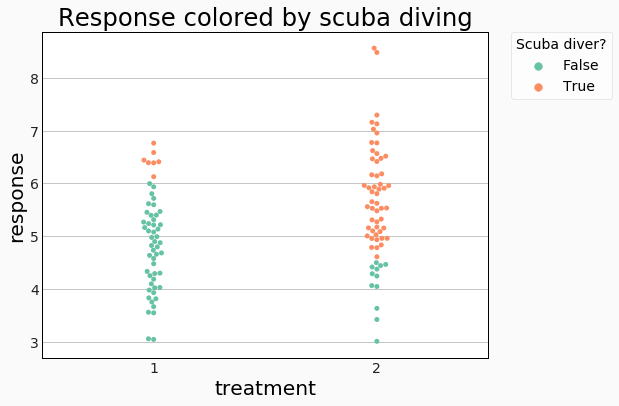

In [15]:
plt.figure(figsize=(8, 6))
pal = sns.color_palette("Set2", 10)
sns.swarmplot(x='treatment', y='response', data=data2, hue='scuba_diving', palette=pal)
plt.title("Response colored by scuba diving")
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Scuba diver?')
plt.show()

Here is an intuitive description of what is happening. People who recover are more likely to go scuba diving, but those on Treatment 2 have to be doing really well to go diving because side effects are so severe. So when we look a scuba divers we get only the most recovered people on Treatment 2. Only the really sick people on Treatment 1 do *not* go scuba diving, so looking at non-scuba divers, Treatment 1 appears worse again.
 
The common sense (causal) conclusion is that Treatment 1 is more effective and scuba diving is a distracting variable which we should ignore.

## For prediction, there is no paradox

Let's consider these examples as a predictive machine learning problems. To distance ourselves from the interpretation, we'll relabel Treatment as $T$, Response as $R$, Location (urban or rural) as $L$, and Scuba diving as $S$. 

In [16]:
data.columns = ['L', 'R', 'T']

In [17]:
data2.columns = ['R', 'S', 'T']

### Example 1 with only treatment data

To begin with, we predict $R$ from $T$ alone. In the table, we show the value of $R$ that is predicted when we observe a certain value of $T$. (It is the mean of $R$ restricted to the group $T=t$ for $t=1,2$.)

In [18]:
data.groupby('T').mean()

,R
T,
1,5.752949
2,4.455171


 The following diagram is a visualization of the predictive model that we would use when only treatment information is available. Upon seeing a new patient, we follow the tree from left to right to arrive at our prediction of the response.

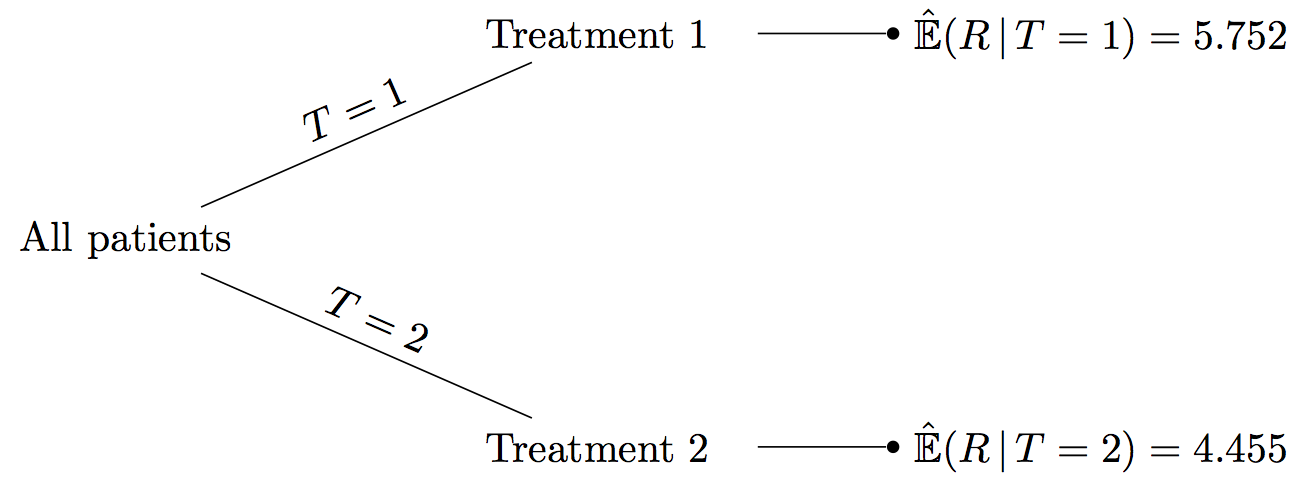

In [19]:
display(Image('img/ex1.1.png'))

This is the best predictive model available if only $T$ had been measured for our new observation (and $L$ was unknown).

### Example 2 with only treatment data

We repeat the calculation for the scuba diving example, assuming that only $T$ had been measured:

In [20]:
data2.drop('S', 1).groupby('T').mean()

,R
T,
1,4.909491
2,5.547824


Here's the tree diagram for this predictive model:

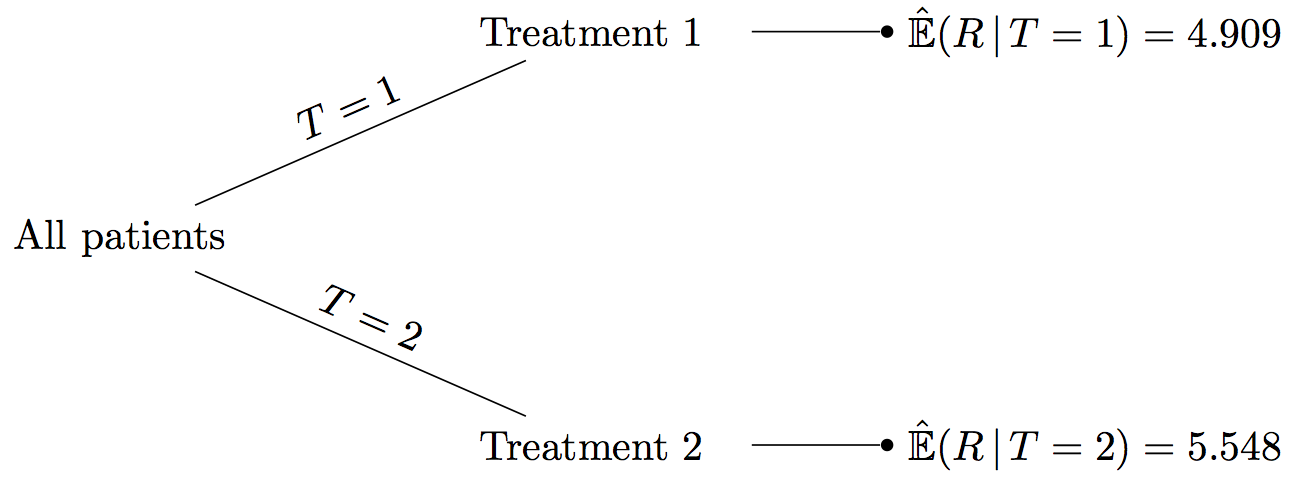

In [21]:
display(Image('img/ex2.1.png'))

### Example 1 with treatment and location data

Now we measure a new feature, $L$. We include this in our model and have four levels of prediction. (Again, these are simply the means of $R$ restricted to one of the four groups.)

In [22]:
data.groupby(['L', 'T']).mean()

R
L     T          
Rural 1  2.186409
      2  3.730602
Urban 1  6.124464
      2  8.595568

For an observation with both $T$ and $L$ measured, our predictive model would become more sophisticated. Once again, we follow the tree from left to right to arrive at a prediction:

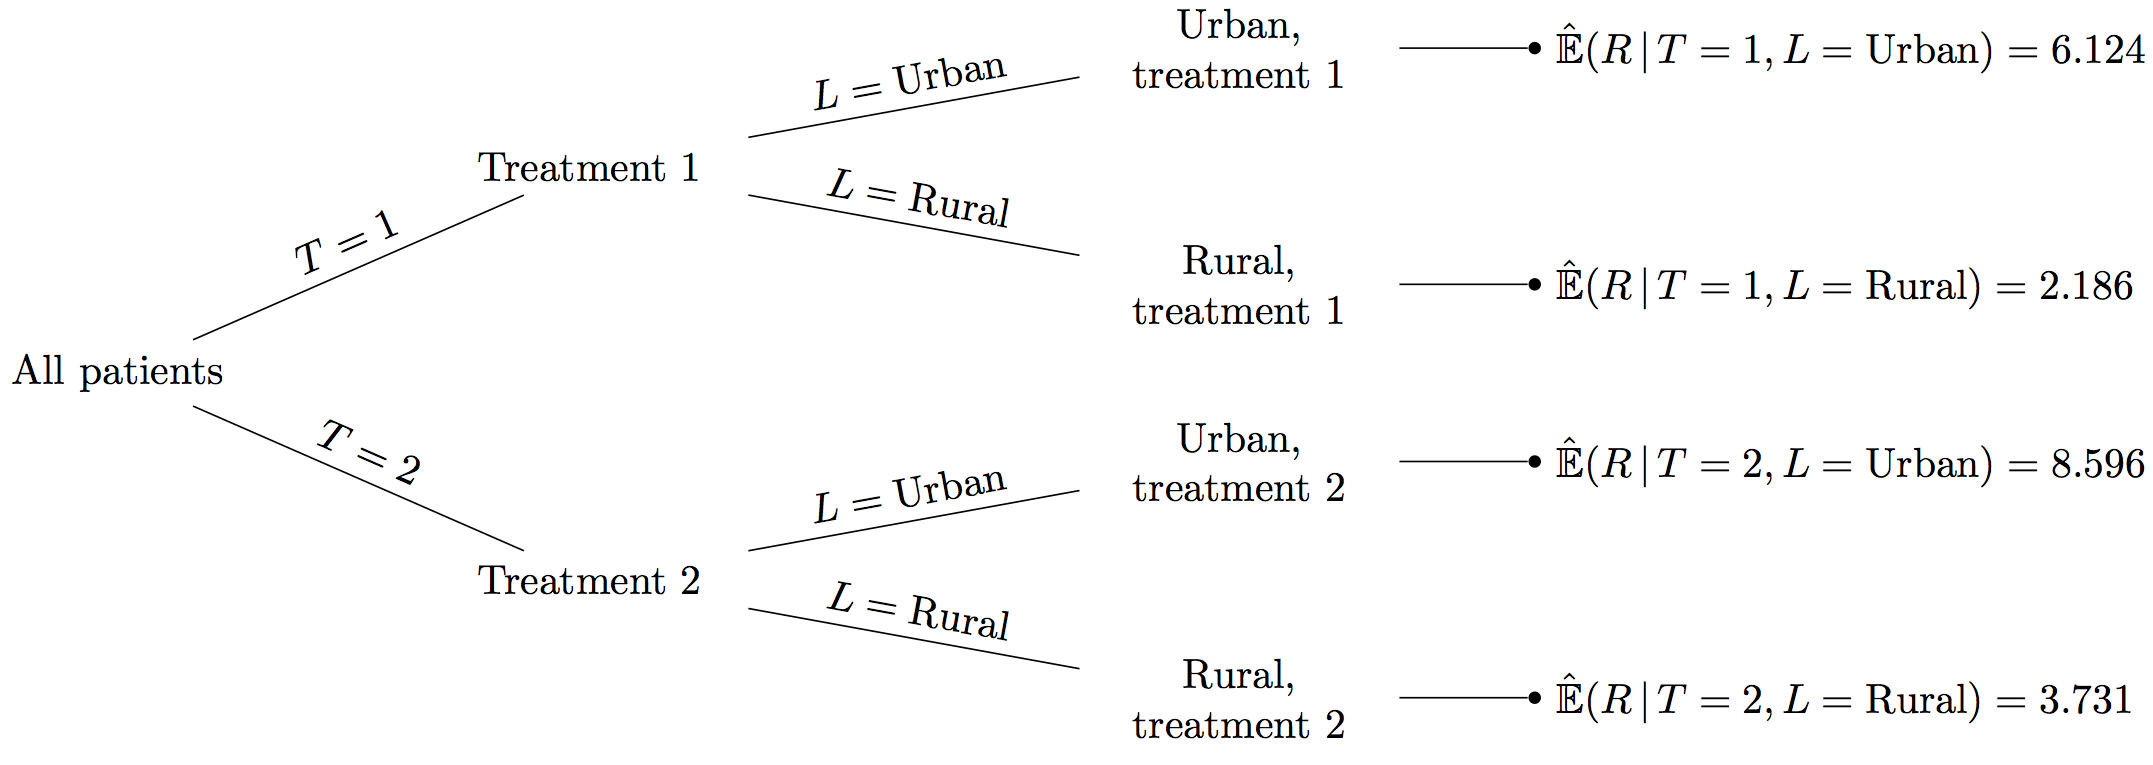

In [23]:
display(Image('img/ex1.2.png'))

### Example 2 with treatment and scuba diving data
For the second example, things proceed much the same when we add a new feature, $S$:

In [24]:
data2.groupby(['S', 'T']).mean()

R
S     T          
False 1  4.690350
      2  4.072883
True  1  6.443475
      2  5.888195

The tree diagram would then be:

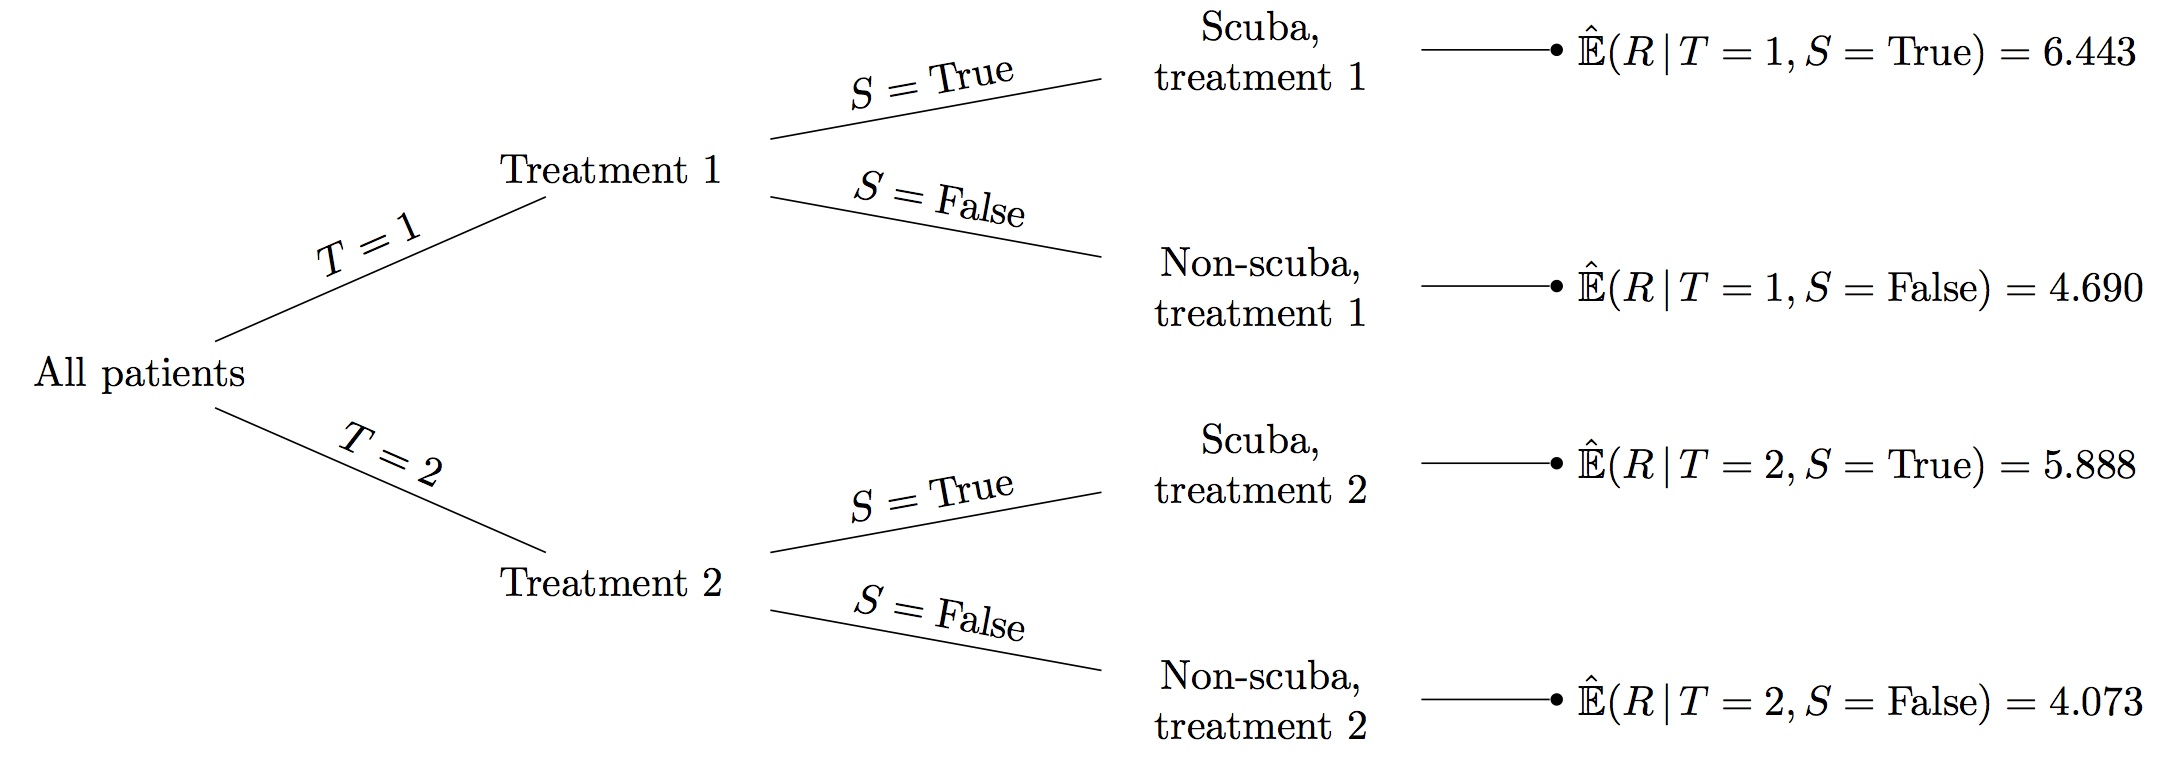

In [25]:
display(Image('img/ex2.2.png'))

### Discussion

From a predictive machine learning point of view, these models are the best we can get for the given features. If we receive a new observation and are told only that the treatment was Treatment 2, then our model tells us what the prediction will be.

For the urban–rural example, it is not important whether the prediction is accurate because the treatment is helping to predict the patient's location, which in turn influences the response. For the scuba diving example, it is not important whether recovery leads to scuba diving or scuba diving leads to recovery.

Thus, if we only want to make predictions, Simpson's Paradox is not a pressing concern. We accept that sometimes trends switch when we add a new feature to the model. That's OK &ndash; we'll know how to make predictions regardless.

## Protecting against Simpson's Paradox when venturing causal inferences

It's only when we want to make causal statements that the paradoxical nature of Simpson's Paradox becomes apparent. Consider our urban–rural example again. It cannot be true medically that Treatment 2 is better overall at curing the disease, but Treatment 1 is better for both subgroups. This is where the air of paradox comes from.
 
The problem lies with the way different variables affect (or [confound](https://en.wikipedia.org/wiki/Confounding)) one another: people in urban areas where the disease is more severe happened to be more likely to be using Treatment 1. That makes it look bad, even though it's a better treatment in fact.

A doctor wishing to prescribe the best treatment would choose Treatment 1. Common sense tells us that the subgroup model is the correct causal model, and the overall model is not. We can encode our common sense in a diagram:

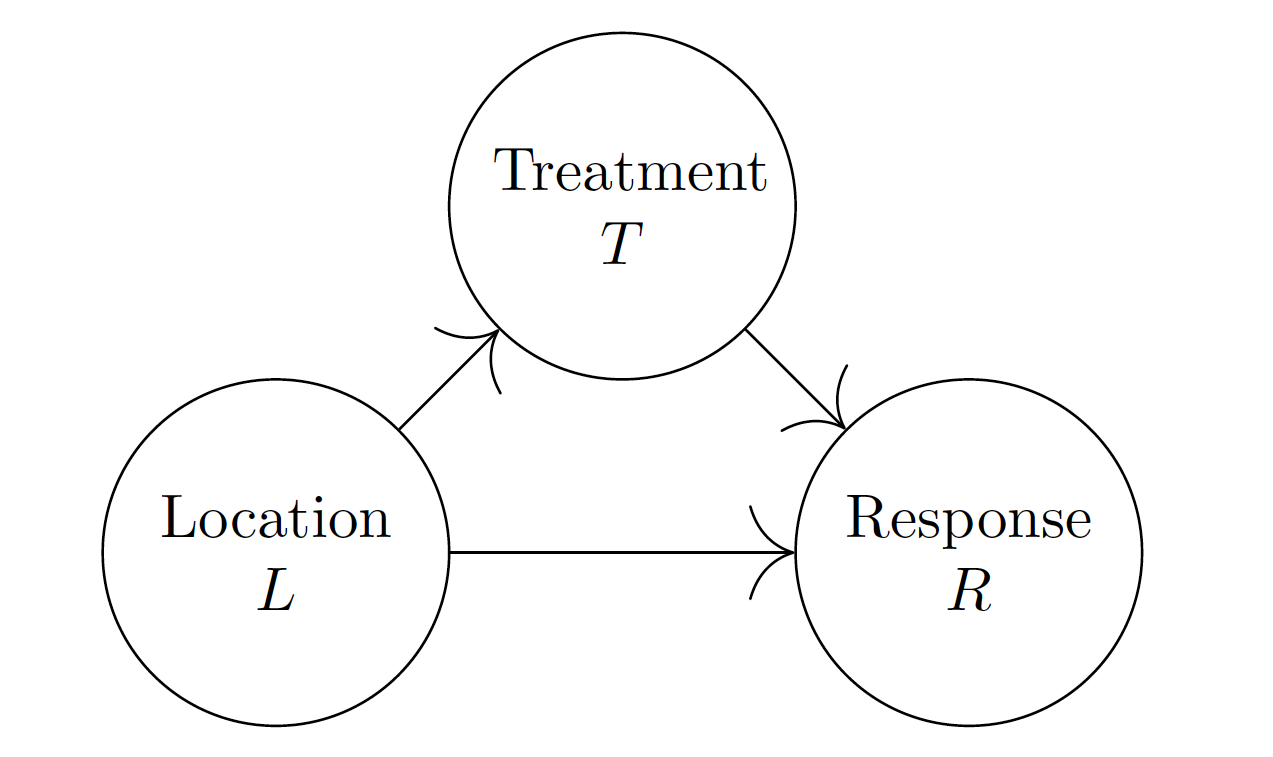

In [26]:
display(Image('img/location.png', width=600))

This encodes our assumption that location influences both treatment and response, and treatment influences response. (A precise mathematical meaning can be attached to such diagrams \cite{pearl2009}.) With this diagram as an assumption, it is possible to deduce that including subgroup information is the right decision in example 1.
 
In contrast, in the scuba-diving example, common sense said that including subgroup information was not the right thing to do, as we do not expect recent scuba-diving history to affect treatment outcomes in this case. The following captures this commonsense view of the problem:

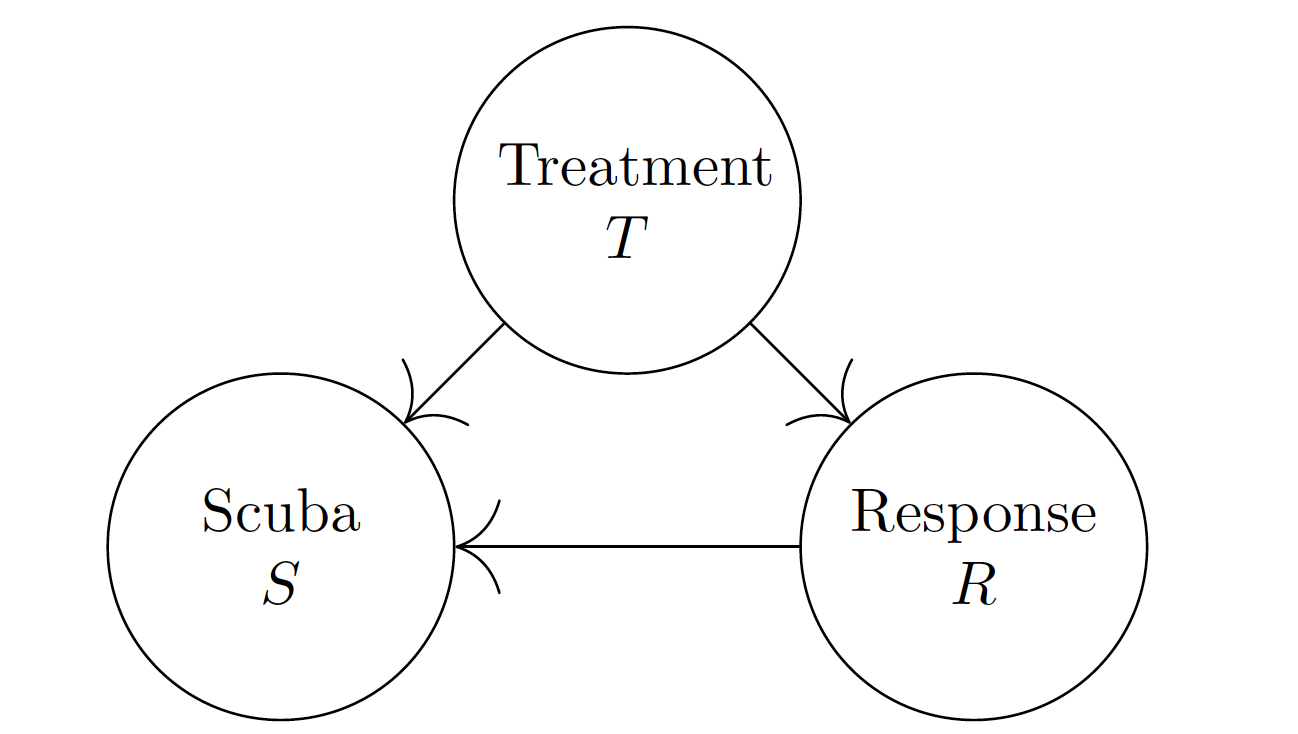

In [27]:
display(Image('img/scuba.png', width=600))

This tells us that $S$ doesn't affect $T$ or $R$ and so we shouldn't include subgroup information when deciding which treatment is more effective. In splitting the population by scuba diving, we were biasing our own data by including treatment and response information in the subgroup definitions. 

(It is tempting to conclude that the temporal ordering of the treatment and the background factor is important. Living in an urban or rural area happens before treatment, so we should consider it in our causal analysis. Scuba diving happens after treatment and can be affected by it, so we shouldn't factor it in to our causal analysis. However, [Appendix B](#Appendix-B:-Temporal-ordering?) shows an example in which the background variable can come before or after the treatment in terms of time.)
  
In summary, we have to make a causal **asumption** to decide which relationship is the "right" one, and the diagrams help us articulate those assumptions. Requiring assumptions is a key feature of causal inference:
 
> behind every causal conclusion there must lie some causal assumption that is not testable in observational studies \cite{pearl2009}
 
When making causal inference from observational studies, there will always be a part to be played by experts and by experimental data.

## Conclusion

Simpson's paradox gives an example where identical underlying statistics yield quite different interpretations depending on whether we take a causal or assoctiational predictive approach. Simpson's paradox is caused by our *causal interpretation* of statistics &ndash; not by the statistics themselves. We saw that predictive models can proceed happily without getting bogged down in causal interpretation.
 
When working with real-world observational data in healthcare, the data themselves convey huge potential. In our first example, we saw that knowing whether a patient was an urban or rural dweller was critical in making the right causal conclusion. However, sometimes extra data is actually harmful to causal studies, as we saw in the second example. Using the data appropriately requires good knowledge of causal inference. There will always be a role for expert judgement and experimental data in such studies. Successful approaches to real-world evidence in healthcare will find ways to combine the benefits of large-scale predictive modeling tools to explore hypotheses and carefully constructed causal inferences to further establish evidence.
 
While this post has shown that faulty causal reasoning leads to paradoxes, there is good news. Researchers have, over the past twenty years, tackled the problem of causal inference in earnest and given us a framework to disentangle ourselves from causal paradoxes. To learn more, Judea Pearl's overview \cite{pearl2009} is a good starting point. This post owes a great deal to Pearl's treatment of Simpson's Paradox \cite{pearl2014}.

## Appendix A: Data simulation

### The simulation for urban-rural example
The simulation in the first example was 

\begin{align*}
L &\sim \text{Bernoulli}\left(\tfrac{1}{2}\right) \\
T\cond L &\sim \text{Bernoulli}\left(\tfrac{7}{8} - \tfrac{3}{4}L\right) + 1 \\
R\cond L, T &\sim N( 2T + 4L, 2) \\
\end{align*}

which matches with the diagram given for example 1.

We can show that Simpson's Paradox is present at the population level:

\begin{align*}
\expect(R\cond T=1) &= 2+ 4\expect(L\cond T=1)\\
&= 2+ 4\prob(L = 1 \cond T=1) \\
&= 2+ 4\prob(T = 1 \cond L=1)\prob(L=1)/\prob(T=1)\\
&= 2 + 4 \cdot \tfrac{7}{8}\\
&= \tfrac{11}{2} \\
\expect(R\cond T=2) &= 4 + 4 \cdot \tfrac{1}{8}\\
&= \tfrac{9}{2}\\
\expect(R\cond T=1) &> \expect(R\cond T=2)
\end{align*}

On the other hand

\begin{align*}
\expect(R\cond T=1, L=0) &= 2\\
\expect(R\cond T=2, L=0) &= 4\\
\expect(R\cond T=1, L=0) &< \expect(R\cond T=2, L=0) \\
\expect(R\cond T=1, L=1) &= 6\\
\expect(R\cond T=2, L=1) &= 8\\
\expect(R\cond T=1, L=1) &< \expect(R\cond T=2, L=1) \\
\end{align*}

### Simulation for the scuba diving example

The simulation in the second example was

\begin{align*}
T &\sim \text{Bernoulli}\left(\tfrac{1}{2}\right) \\
R\cond T &\sim N\left(5 + \tfrac{1}{2}T, 1\right) + 1 \\
S\cond R, T &= I(T=0)I(R>7) + I(T=1)I(R>5.5) \\
\end{align*}

which matches the diagram given for example 2.

A little calculation will show that Simpson's Paradox arises at the population level.


## Appendix B: Temporal ordering?

### The issue

A tempting generalization is that the temporal ordering of the treatment and the background factor is important. This appendix presents an example in which this fails to hold.

### Mathematical details

Here is an example where the background variable can come before *or* after the treatment in terms of time. Whichever way round it is, it's still right to break into subgroups for that particular example:

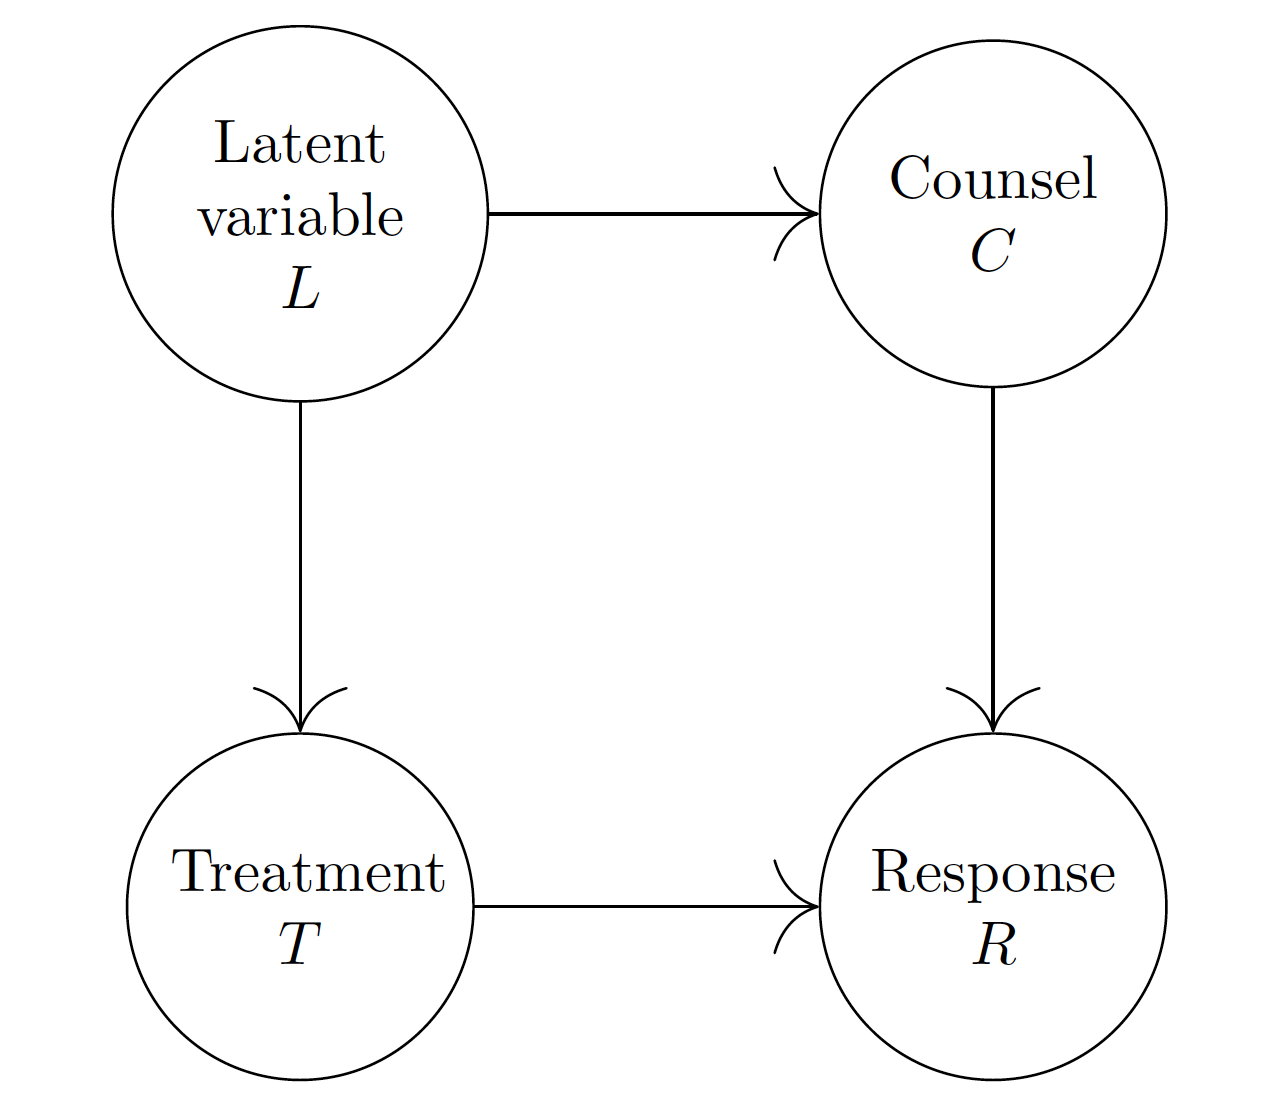

In [28]:
display(Image('img/counsel.png', width=600))

The idea here is that both treatment and counsel are being used to counter the effects of the disease. Which therapeutic options a patient chooses is determined by some latent variable (which is unobserved). Notice that treatment and counsel can occur in any temporal order. Nevertheless, it's always right to split on subgroups using $C$. Hopefully it makes sense that we should consider those who did and didn't have counsel separately.

Here is a concrete example to show that Simpson's Paradox can arise in this case.

\begin{align*}
L &\sim \text{Bernoulli}\left(\tfrac{1}{2}\right) \\
T\cond L &\sim \text{Bernoulli}\left(\tfrac{7}{8} - \tfrac{3}{4}L\right) + 1 \\
C\cond L &\sim \text{Bernoulli}\left(\tfrac{1}{8} + \tfrac{3}{4}L\right) \\
R\cond C, T &\sim N( T + 8C, 2) \\
\end{align*}

Then

\begin{align*}
\expect(R \cond T=1) &= 1 + 8\expect(C\cond T=1) \\
&= 1 + 8\prob(C=1 \cond T=1) \\
&= 1 + 8\prob(C=1, T=1)\,/\,\prob(T=1) \\
&= 1 + 16\prob(C=1, T=1) \\
&= 1 + 16\left(\prob(C=1, T=1, L=0) + \prob(C=1, T=1, L=1)\right) \\
&= 1 + 8\left(\tfrac{1}{8}\cdot \tfrac{1}{8} + \tfrac{7}{8}\cdot \tfrac{7}{8}\right) \\
&= 1 + \tfrac{25}{4} \\
&= \tfrac{29}{4} \\
\expect(R \cond T=2) &= 2 + 8\left(\tfrac{1}{8}\cdot \tfrac{7}{8} + \tfrac{7}{8}\cdot \tfrac{1}{8}\right) \\
&= \tfrac{15}{4} \\
\expect(R \cond T=1) &> \expect(R \cond T=2)
\end{align*}

On the other hand

\begin{align*}
\expect(R\cond T=1, C=0) &= 1\\
\expect(R\cond T=2, C=0) &= 2\\
\expect(R\cond T=1, C=0) &< \expect(R\cond T=2, C=0) \\
\expect(R\cond T=1, C=1) &= 9\\
\expect(R\cond T=2, C=1) &= 10\\
\expect(R\cond T=1, C=1) &< \expect(R\cond T=2, C=1) \\
\end{align*}


### The correct generalization

The correct generalization is something called the *Back-door criterion* \cite{pearl2009}. It tells us, based on diagrams like the one above, which variables we should be using to break into subgroups, and which we should ignore.

# References

[<a id="cit-tu2008" href="#call-tu2008">4</a>] Tu, Yu-Kang and Gunnell, David and Gilthorpe, Mark S., _Simpson's Paradox, Lord's Paradox, and Suppression Effects are the same phenomenon -- the reversal paradox_, Emerging Themes in Epidemiology, vol. 5, number 1, pp. 2,  2008.

[<a id="cit-pearl2003" href="#call-pearl2003">1</a>] Pearl, Judea, _Causality: models, reasoning and inference_, Econometric Theory, vol. 19, number 675–685, pp. 46,  2003.

[<a id="cit-pearl2009" href="#call-pearl2009">2</a>] Pearl, Judea, _Causal inference in statistics: An overview_, Statistics Surveys, vol. 3, number 1, pp. 96–146,  2009.

[<a id="cit-pearl2014" href="#call-pearl2014">3</a>] Pearl, Judea. _Comment: understanding Simpson's paradox_, The American Statistician, vol. 68, number 1, pp. 8–13,  2014.

[<a id="cit-victora2004" href="#call-victora2004">5</a>] Victora, Cesar G. and Habicht, Jean-Pierre and Bryce, Jennifer, _Evidence-based public health: moving beyond randomized trials_, American Journal of Public Health, vol. 94, number 3, pp. 400–405,  2004.